<center>

# Customer Analysis

</center>

This notebook focuses on deep customer behavior analysis based on the Brazilian E-commerce dataset.

Objective:
- Understand revenue distribution across customers
- Identify high-value segments
- Analyze revenue concentration
- Explore customer value patterns

## 1. Environment Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FIG_WIDTH = 10
FIG_HEIGHT = 6

## 2. Data Loading

In [3]:
orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")
order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")

## 3. Data Preparation

In [4]:
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"]
)

delivered_orders = orders[orders["order_status"] == "delivered"]

df = delivered_orders.merge(
    order_items,
    on="order_id",
    how="left"
)

df["revenue"] = df["price"] + df["freight_value"]

df = df.merge(
    customers[["customer_id", "customer_unique_id"]],
    on="customer_id",
    how="left"
)

## 4. Customer Order Distribution

This section analyzes how many orders each customer has placed. The goal is to understand repeat behavior and order frequency distribution.

#### 4.1 Calculate Order Count per Customer

In [5]:
customer_orders = (
    df.groupby("customer_unique_id")["order_id"]
      .nunique()
      .reset_index()
      .rename(columns={"order_id": "order_count"})
)

customer_orders.head()

,customer_unique_id,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


#### 4.2 Distribution Summary

In [6]:
customer_orders["order_count"].value_counts().sort_index()

order_count
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

#### 4.3 Visualization

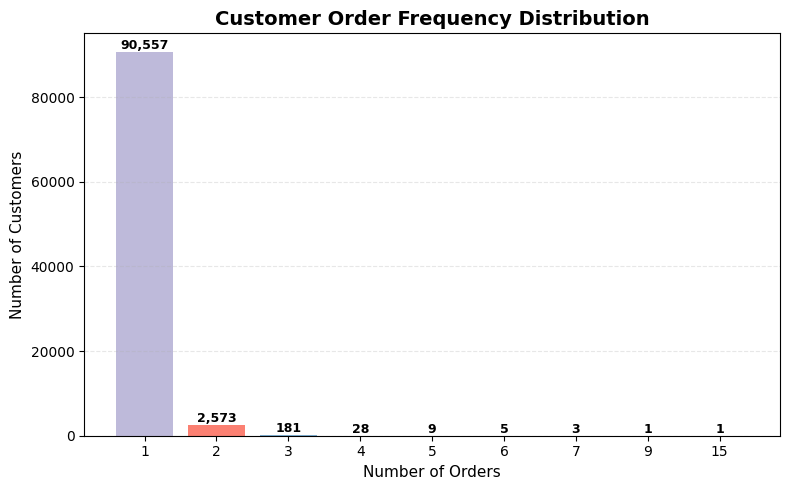

In [7]:
import matplotlib.pyplot as plt
import numpy as np

FIG_WIDTH = 8
FIG_HEIGHT = 5

distribution = (
    customer_orders["order_count"]
    .value_counts()
    .sort_index()
)

# Color palette
COLOR_PALETTE = plt.cm.Set3(np.linspace(0.2, 0.8, len(distribution)))

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

bars = plt.bar(
    distribution.index.astype(str),
    distribution.values,
    color=COLOR_PALETTE
)

plt.title("Customer Order Frequency Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Orders", fontsize=11)
plt.ylabel("Number of Customers", fontsize=11)

plt.grid(axis="y", alpha=0.3, linestyle="--")

# Value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

#### 4.4 Log Scale

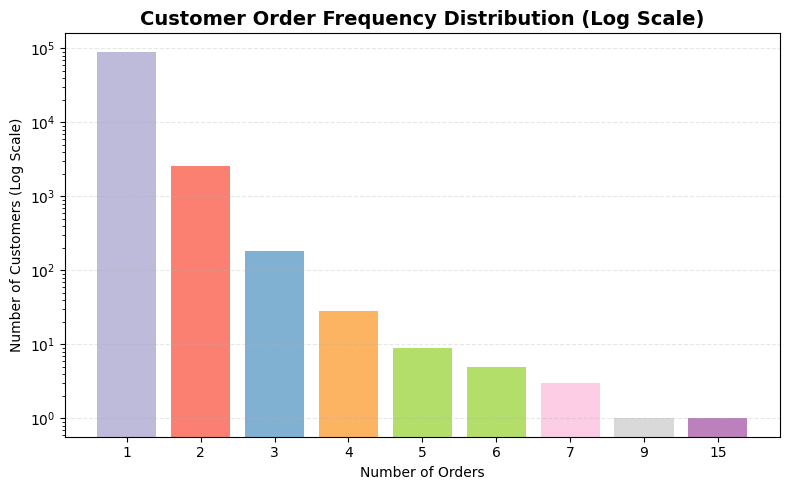

In [8]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

bars = plt.bar(
    distribution.index.astype(str),
    distribution.values,
    color=COLOR_PALETTE
)

plt.yscale("log")

plt.title("Customer Order Frequency Distribution (Log Scale)", fontsize=14, fontweight="bold")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers (Log Scale)")

plt.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

#### 4.5 Customer Segmentation (Order Frequency Based Buckets)

To better understand customer loyalty behavior, customers are segmented based on the number of orders they have placed.

This segmentation allows us to distinguish between:
- One-time buyers
- Occasional buyers
- Regular customers
- Loyal customers

By grouping customers into behavioral segments, we can evaluate retention strength and identify the proportion of high-value returning customers.

##### Key Insight

The customer base is heavily dominated by one-time buyers (97%).
Only a very small fraction of customers fall into the regular or loyal segments.

This indicates a significant retention issue, suggesting that the business relies heavily on customer acquisition rather than long-term customer value.

Improving retention strategies could dramatically increase overall revenue stability.

##### 4.5.1 Create Segments

In [9]:
def segment_customer(order_count):
    if order_count == 1:
        return "One-Time"
    elif order_count == 2:
        return "Occasional"
    elif order_count in [3, 4]:
        return "Regular"
    else:
        return "Loyal"

customer_orders["customer_segment"] = customer_orders["order_count"].apply(segment_customer)

customer_orders.head()

,customer_unique_id,order_count,customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,One-Time
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,One-Time
2,0000f46a3911fa3c0805444483337064,1,One-Time
3,0000f6ccb0745a6a4b88665a16c9f078,1,One-Time
4,0004aac84e0df4da2b147fca70cf8255,1,One-Time


##### 4.5.2 Segment Distribution

In [10]:
segment_distribution = (
    customer_orders["customer_segment"]
    .value_counts()
)

segment_distribution

customer_segment
One-Time      90557
Occasional     2573
Regular         209
Loyal            19
Name: count, dtype: int64

##### 4.5.3 Percentage Distribution

In [11]:
segment_percentage = (
    segment_distribution / segment_distribution.sum() * 100
).round(2)

segment_percentage

customer_segment
One-Time      97.00
Occasional     2.76
Regular        0.22
Loyal          0.02
Name: count, dtype: float64

#### 4.6 Segment Revenue Contribution

##### Revenue Structure Analysis

The revenue distribution closely follows the customer distribution pattern.

- One-time customers generate 94.4% of total revenue.
- Occasional customers contribute 4.86%.
- Regular and Loyal segments together account for less than 1% of total revenue.

This indicates that the business model is heavily dependent on first-time purchases rather than repeat behavior.

##### Strategic Implication

Such a revenue structure presents a structural risk. 
If customer acquisition channels weaken, revenue may decline rapidly due to the lack of a strong repeat customer base.

A sustainable growth strategy would require:
- Increasing repeat purchase rates
- Implementing loyalty programs
- Developing remarketing strategies
- Improving post-purchase engagement

Strengthening customer retention could significantly improve long-term revenue stability and customer lifetime value (LTV).


##### Key Insight

Revenue distribution mirrors customer distribution. 

Over 94% of total revenue comes from one-time buyers, while loyal customers contribute less than 1% of total revenue.

This indicates a strong dependency on new customer acquisition rather than sustainable customer retention.

Improving retention strategies could significantly increase customer lifetime value and revenue stability.

##### 4.6.1 Merge Revenue Back

In [12]:
df_segmented = df.merge(customer_orders[["customer_unique_id", "customer_segment"]], on="customer_unique_id", how="left")
df_segmented.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,revenue,customer_unique_id,customer_segment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,38.71,7c396fd4830fd04220f754e42b4e5bff,Occasional
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,141.46,af07308b275d755c9edb36a90c618231,One-Time
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,179.12,3a653a41f6f9fc3d2a113cf8398680e8,One-Time
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,72.20,7c142cf63193a1473d2e66489a9ae977,One-Time
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,28.62,72632f0f9dd73dfee390c9b22eb56dd6,One-Time


##### 4.6.2 Revenue by Segment

In [13]:
segment_revenue = (
    df_segmented.groupby("customer_segment")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

segment_revenue

,customer_segment,revenue
0,One-Time,14555586.29
1,Occasional,748811.57
2,Regular,100420.20
3,Loyal,14955.69


##### 4.6.3 Revenue Percentage

In [14]:
segment_revenue["Revenue %"] = (
    segment_revenue["revenue"] / segment_revenue["revenue"].sum() * 100
).round(2)

segment_revenue

,customer_segment,revenue,Revenue %
0,One-Time,14555586.29,94.40
1,Occasional,748811.57,4.86
2,Regular,100420.20,0.65
3,Loyal,14955.69,0.10


##### 4.6.4 Visualization

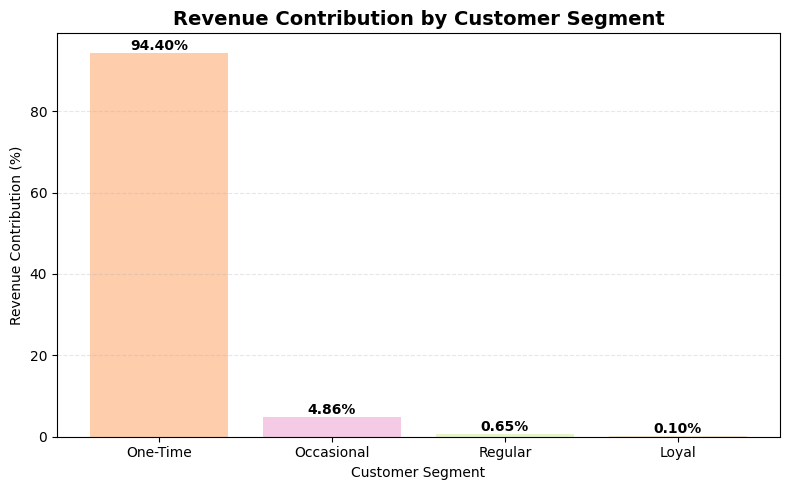

In [15]:
import matplotlib.pyplot as plt
import numpy as np

FIG_WIDTH = 8
FIG_HEIGHT = 5

COLOR_PALETTE = plt.cm.Pastel2(np.linspace(0.2, 0.8, len(segment_revenue)))

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

bars = plt.bar(
    segment_revenue["customer_segment"],
    segment_revenue["Revenue %"],
    color=COLOR_PALETTE
)

plt.title("Revenue Contribution by Customer Segment", fontsize=14, fontweight="bold")
plt.xlabel("Customer Segment")
plt.ylabel("Revenue Contribution (%)")

plt.grid(axis="y", alpha=0.3, linestyle="--")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

#### 4.7 Basic Customer Lifetime Value (LTV Approximation)

##### Basic LTV Interpretation

The estimated customer lifetime value (LTV) is approximately $170.

Since the average purchase frequency is only 1.03, the lifetime value is almost equal to a single order value.

This indicates extremely low customer retention and minimal repeat behavior.

If customer acquisition cost (CAC) approaches or exceeds this value, long-term profitability may be at risk.

##### 4.7.1 Average Purchase Frequency

In [16]:
avg_purchase_frequency = customer_orders["order_count"].mean()
avg_purchase_frequency

np.float64(1.0334197390689603)

##### 4.7.2 Average Order Value (Overall)

In [17]:
overall_aov = df["revenue"].sum() / customer_orders["customer_unique_id"].nunique()
overall_aov

np.float64(165.1682100087834)

##### 4.7.3 Basic LTV Calculation

In [18]:
basic_ltv = overall_aov * avg_purchase_frequency

print(f"Average Purchase Frequency: {avg_purchase_frequency:.2f}")
print(f"Average Average Order Value (AOV): ${overall_aov:.2f}")
print(f"Estimated Basic LTV: ${basic_ltv:.2f}")

Average Purchase Frequency: 1.03
Average Average Order Value (AOV): $165.17
Estimated Basic LTV: $170.69


#### 4.8 High-Value Customers

##### High-Value Customer Insight

The top 10% of customers generate approximately 38% of total revenue.

This indicates moderate revenue concentration, but not a strong Pareto structure.
The business does not appear to rely heavily on a small high-value customer base.

Combined with the low repeat rate, this suggests that revenue is distributed across many low-frequency customers rather than driven by loyal, high-LTV segments.

##### Pareto Insight

The Pareto curve shows that revenue concentration is relatively moderate.

Approximately 50% of customers are required to generate 80% of total revenue, indicating a lack of strong revenue concentration among top customers.

This reinforces the earlier finding that the business does not rely on a highly loyal, high-value customer base.

##### 4.8.1 Revenue per Customer

In [19]:
customer_revenue = (
    df.groupby("customer_unique_id")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

customer_revenue.head()

,customer_unique_id,revenue
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21


##### 4.8.2 Revenue Percentage Contribution

In [20]:
customer_revenue["Revenue %"] = (
    customer_revenue["revenue"] /
    customer_revenue["revenue"].sum() * 100
)

customer_revenue["Cumulative %"] = (
    customer_revenue["Revenue %"].cumsum()
)

customer_revenue.head()

,customer_unique_id,revenue,Revenue %,Cumulative %
0,0a0a92112bd4c708ca5fde585afaa872,13664.08,0.088614,0.088614
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63,0.049103,0.137717
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88,0.047179,0.184896
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31,0.044938,0.229834
4,459bef486812aa25204be022145caa62,6922.21,0.044892,0.274726


##### 4.8.3 Top 10% Customer Contribution

In [21]:
top_10_cutoff = int(len(customer_revenue) * 0.10)

top_10_revenue_share = customer_revenue.iloc[:top_10_cutoff]["Revenue %"].sum()

print(f"Top 10% customers generate: {top_10_revenue_share:.2f}% of total revenue")

Top 10% customers generate: 38.25% of total revenue


##### 4.8.4 Vusialization - Customer Pareto Curve

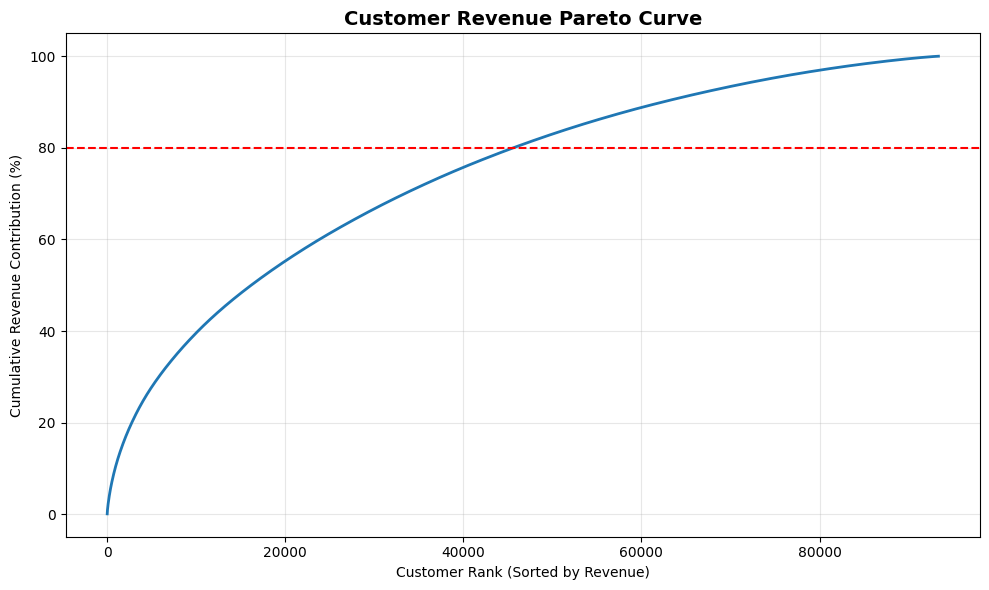

In [22]:
import matplotlib.pyplot as plt

FIG_WIDTH = 10
FIG_HEIGHT = 6

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.plot(
    customer_revenue["Cumulative %"],
    linewidth=2
)

plt.axhline(y=80, color="red", linestyle="--", linewidth=1.5)

plt.title("Customer Revenue Pareto Curve", fontsize=14, fontweight="bold")
plt.xlabel("Customer Rank (Sorted by Revenue)")
plt.ylabel("Cumulative Revenue Contribution (%)")

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 4.9 Customer Analysis - Executive Summary

##### Customer Structure Overview

The customer base is heavily dominated by one-time buyers, representing approximately 97% of all customers.

Repeat behavior is extremely limited:
- Occasional customers: ~2.7%
- Regular customers: ~0.2%
- Loyal customers: ~0.02%

This indicates a significant retention weakness.

---

##### Revenue Structure

Revenue distribution mirrors customer distribution:

- 94% of total revenue comes from one-time buyers.
- Loyal customers contribute less than 1% of revenue.

The business does not rely on a strong high-value customer base.

---

##### Lifetime Value (LTV)

The estimated basic LTV is approximately $170.

Since average purchase frequency is only 1.03, customer lifetime value is almost equal to a single transaction.

This suggests limited long-term monetization per customer.

---

##### Revenue Concentration (Pareto Analysis)

The top 10% of customers generate only 38% of total revenue.

Approximately half of the customer base is required to generate 80% of revenue.

This indicates moderate revenue concentration but no dominant VIP segment.

---

##### Strategic Implications

The business model appears highly acquisition-driven and weak in retention.

Potential strategic improvements:

- Implement loyalty programs
- Strengthen post-purchase engagement
- Improve remarketing campaigns
- Introduce subscription or repeat incentives
- Develop customer lifecycle marketing

Improving retention could significantly increase customer lifetime value and revenue stability.